In [33]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from xgboost import XGBClassifier


pd.set_option('display.max_columns', None)

random_state = 42

# Funciones

In [2]:
class FrequencySamplerImputer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=random_state):
        self.random_state = random_state

    def fit(self, X, y=None):
        x = np.array(X).ravel()
        mask = pd.isna(x)
        observed = x[~mask]

        if observed.size == 0:
            raise ValueError("No hay categorías observadas para imputar.")

        vals, counts = np.unique(observed, return_counts=True)
        self.categories_ = vals
        self.probs_ = counts / counts.sum()
        return self

    def transform(self, X):
        rng = np.random.default_rng(self.random_state)
        x = np.array(X).ravel()
        mask = pd.isna(x)
        n_missing = int(mask.sum())

        if n_missing > 0:
            x[mask] = rng.choice(self.categories_, size=n_missing, replace=True, p=self.probs_)

        return x.reshape(-1, 1)

# Columnas descartadas
Dado el EDA, se muestran las razones por las cuales se descartaron las siguientes variables:

### Target leakage
- SHORT_DESC: Leakage -> Relación 1-1 con CLASS

### IDs
- P_ID: Identificador único
- TAX_MAP: Identificador/código casi único

### Redundancia
- SHORT_DESC 1: Redundante con LEVY_CODE_1

### Dirección exacta / alta cardinalidad / PII (riesgo + no generaliza)
- FORMATED_ADDRESS: Dirección completa (alta cardinalidad, PII).
- STREET: Nombre de calle (alta cardinalidad, PII).
- SUFFIX: Parte de dirección; redundante con STREET (Cramér’s V alto) y poca utilidad.
- CIVIC: Número de dirección; sensible y ligado a dirección (riesgo/atajo).
- FREE_LINE_2: Texto libre de mailing (alta cardinalidad, PII).
- FIRST_NAME: PII (nombre).
- LAST_NAME: PII (apellido).
- COMPANY: PII/alta cardinalidad

### Mailing address
- CIVIC 1
- STREET 1
- S_SUFFIX
- CITY 1
- STATE
- ZIP_POSTAL 1

### Unidades
- unit: Alta cardinalidad
- UNIT: Redundante/relacionada con unit

### Geografía en formato string / derivaciones no usadas
- Property_Location: Se usa solo para extraer lat/lon
- geo_cell: Demasiado granular y poco aporte



# Columnas seleccionadas

In [3]:
target = "CLASS"

num_features_final = [
    "TOTAL_ASSMT",
    "TOTAL_TAXES",
    "TOTAL_EXEMPT",
    "lat",
    "lon",
]

cat_features_final = [
    "LEVY_CODE_1",
    "geo_cluster",
    "ZIP_POSTAL", 
]

features_final = num_features_final + cat_features_final

In [4]:
DATA_PATH = "../data/2024_Property_Tax_Roll.csv"
df_ = pd.read_csv(DATA_PATH)

coords = df_["Property_Location"].str.extract(r"POINT\s*\(\s*([-\d\.]+)\s+([-\d\.]+)\s*\)")
df_.loc[:,"lon"] = pd.to_numeric(coords[0], errors="coerce")
df_.loc[:,"lat"] = pd.to_numeric(coords[1], errors="coerce")

valid = df_[["lat", "lon"]].dropna()
kmeans = KMeans(n_clusters=10, random_state=random_state)
df_.loc[valid.index, "geo_cluster"] = kmeans.fit_predict(valid)

df_["geo_cluster"] = df_["geo_cluster"].astype("Int64").astype(str)


In [5]:
df_model = df_.dropna(subset=[target]).copy()

X = df_model[features_final].copy()
y = df_model[target].astype("Int64").astype(str)

X.shape, y.shape

((44033, 8), (44033,))

In [6]:
df_model[features_final].isna().sum().sort_values(ascending=False)

ZIP_POSTAL      1436
TOTAL_ASSMT        0
TOTAL_EXEMPT       0
TOTAL_TAXES        0
lat                0
lon                0
LEVY_CODE_1        0
geo_cluster        0
dtype: int64

In [7]:
(X.isnull().mean().mul(100).sort_values(ascending=False))


ZIP_POSTAL      3.26119
TOTAL_ASSMT     0.00000
TOTAL_EXEMPT    0.00000
TOTAL_TAXES     0.00000
lat             0.00000
lon             0.00000
LEVY_CODE_1     0.00000
geo_cluster     0.00000
dtype: float64

# Separación train_test

In [8]:
y_int = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=random_state, stratify=y_int)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((35226, 8), (8807, 8), (35226,), (8807,))

In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

le.classes_

array([ 1,  2,  3,  4,  5,  6,  7, 10, 12, 13, 14, 23, 24, 33, 70, 71, 72,
       73, 74, 75, 76, 78, 79, 80, 82, 83, 84])

In [10]:
# Distribución de clases (proporciones) para confirmar estratificación
dist_train = y_train.value_counts(normalize=True).sort_index()
dist_test  = y_test.value_counts(normalize=True).sort_index()

dist_train.head(), dist_test.head()


(CLASS
 1    0.334412
 2    0.317691
 3    0.011696
 4    0.016408
 5    0.000596
 Name: proportion, dtype: float64,
 CLASS
 1    0.334393
 2    0.317702
 3    0.011695
 4    0.016464
 5    0.000568
 Name: proportion, dtype: float64)

## Preprocesamiento

In [11]:
num_features_final = ["TOTAL_ASSMT", "TOTAL_TAXES", "TOTAL_EXEMPT", "lat", "lon"]
cat_features_final = ["LEVY_CODE_1", "geo_cluster"]
zip_feature = ["ZIP_POSTAL"]

# Pipelines
numeric_pipe_scaled = Pipeline([
    ("scaler", StandardScaler()),
])

numeric_pipe_raw = "passthrough" 

cat_pipe = Pipeline([
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

zip_pipe = Pipeline([
    ("imp_freq", FrequencySamplerImputer(random_state=random_state)),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocesador final
# Modelos que necesitan estandarización
preprocess_scaled = ColumnTransformer([
    ("num", numeric_pipe_scaled, num_features_final),
    ("cat", cat_pipe,          cat_features_final),
    ("zip", zip_pipe,          zip_feature),
], remainder="drop")

# Modelos que no necesitan estandarización
preprocess_raw = ColumnTransformer([
    ("num", numeric_pipe_raw,  num_features_final),
    ("cat", cat_pipe,          cat_features_final),
    ("zip", zip_pipe,          zip_feature),
], remainder="drop")



# Selección de modelo
- Se usarán 5 modelos para determinar cuál arroja mejores resultados

In [12]:
# Se guardan ids

id_cols = ["P_ID", "TAX_MAP"]
ids_train = df_model.loc[X_train.index, id_cols].copy()
ids_test  = df_model.loc[X_test.index, id_cols].copy()

In [13]:
to_dense = FunctionTransformer(
    lambda x: x.toarray() if hasattr(x, "toarray") else x,
    accept_sparse=True
)

In [14]:
models = {
    "LR": LogisticRegression(
        solver="saga",
        max_iter=5000,
        class_weight="balanced",
        random_state=random_state
    ),

    "SGD": SGDClassifier(
        loss="log_loss",
        alpha=1e-4,
        max_iter=3000,
        tol=1e-3,
        class_weight="balanced",
        random_state=random_state
    ),

    "RF": RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced_subsample",
        random_state=random_state
    ),

    "GradientBoosting": GradientBoostingClassifier(
        n_estimators = 100, 
        learning_rate= 0.03, 
        max_depth = 3, 
        random_state=random_state
        ),

    "AdaBoost": AdaBoostClassifier(
        n_estimators=100, 
        learning_rate=0.03, 
        random_state=random_state
        ),

    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=len(le.classes_),
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=random_state,
    )
}


In [15]:
pipelines = {}

pipelines["LR"] = Pipeline([
    ("pre", preprocess_scaled),
    ("model", models["LR"])
])

pipelines["SGD"] = Pipeline([
    ("pre", preprocess_scaled),
    ("model", models["SGD"])
])

pipelines["RF"] = Pipeline([
    ("pre", preprocess_raw),
    ("model", models["RF"])
])

pipelines["GradientBoosting"] = Pipeline([
    ("pre", preprocess_raw),
    ("dense", to_dense),
    ("model", models["GradientBoosting"])
])

pipelines["AdaBoost"] = Pipeline([
    ("pre", preprocess_raw),
    ("dense", to_dense),
    ("model", models["AdaBoost"])
])

pipelines["XGBoost"] = Pipeline([
        ("pre", preprocess_raw),
        ("model", models["XGBoost"])
    ])

## Selección mejor modelo

In [16]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state)

results = []
for name, pipe in pipelines.items():
    print(name)
    scores = cross_validate(
        pipe,
        X_train,
        y_train_enc,
        cv=cv,
        scoring={"acc": "accuracy", "f1m": "f1_macro"},
        return_train_score=False
    )
    results.append({
        "model": name,
        "acc_mean": float(np.mean(scores["test_acc"])),
        "acc_std": float(np.std(scores["test_acc"])),
        "f1_macro_mean": float(np.mean(scores["test_f1m"])),
        "f1_macro_std": float(np.std(scores["test_f1m"])),
    })

result_cv = pd.DataFrame(results).sort_values("f1_macro_mean", ascending=False).reset_index(drop=True)
result_cv

LR


/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SGD
RF
GradientBoosting
AdaBoost
XGBoost


,model,acc_mean,acc_std,f1_macro_mean,f1_macro_std
0,XGBoost,0.808068,0.002356,0.520501,0.005170
1,RF,0.793334,0.000284,0.519170,0.005567
2,GradientBoosting,0.748424,0.004088,0.439290,0.004089
3,LR,0.580055,0.002924,0.322591,0.004926
4,SGD,0.549339,0.000653,0.255844,0.003378
5,AdaBoost,0.430847,0.001845,0.051926,0.001197


## Entrenamiento mejor modelo.
- Se escoge XGBoost

In [19]:
best_name = result_cv["model"].values[0]
best_pipe = pipelines[best_name]

best_pipe.fit(X_train, y_train_enc)


,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Predicción

In [ ]:
y_pred_enc = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)

# volver a clases originales
y_pred = le.inverse_transform(y_pred_enc)
y_true = y_test

## Métricas

In [26]:
acc = accuracy_score(y_true, y_pred)
acc

0.8352446917224935

/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

              precision    recall  f1-score   support

           1     0.8404    0.8472    0.8438      2945
           2     0.8421    0.8485    0.8453      2798
           3     0.6228    0.6893    0.6544       103
           4     0.7179    0.5793    0.6412       145
           5     0.1667    0.2000    0.1818         5
           6     0.5685    0.6842    0.6210       285
           7     0.5556    0.4369    0.4891       103
          10     1.0000    0.1667    0.2857         6
          12     1.0000    1.0000    1.0000       124
          13     0.9934    0.9820    0.9876       610
          14     0.8797    0.8339    0.8562       307
          23     0.9335    0.8900    0.9113       773
          24     0.8810    0.8706    0.8757        85
          70     0.0000    0.0000    0.0000         3
          71     0.5625    0.5000    0.5294        72
          72     0.6316    0.6593    0.6452        91
          73     0.0000    0.0000    0.0000         1
          74     1.0000    

Text(0.5, 1.0, 'Matriz de confusión')

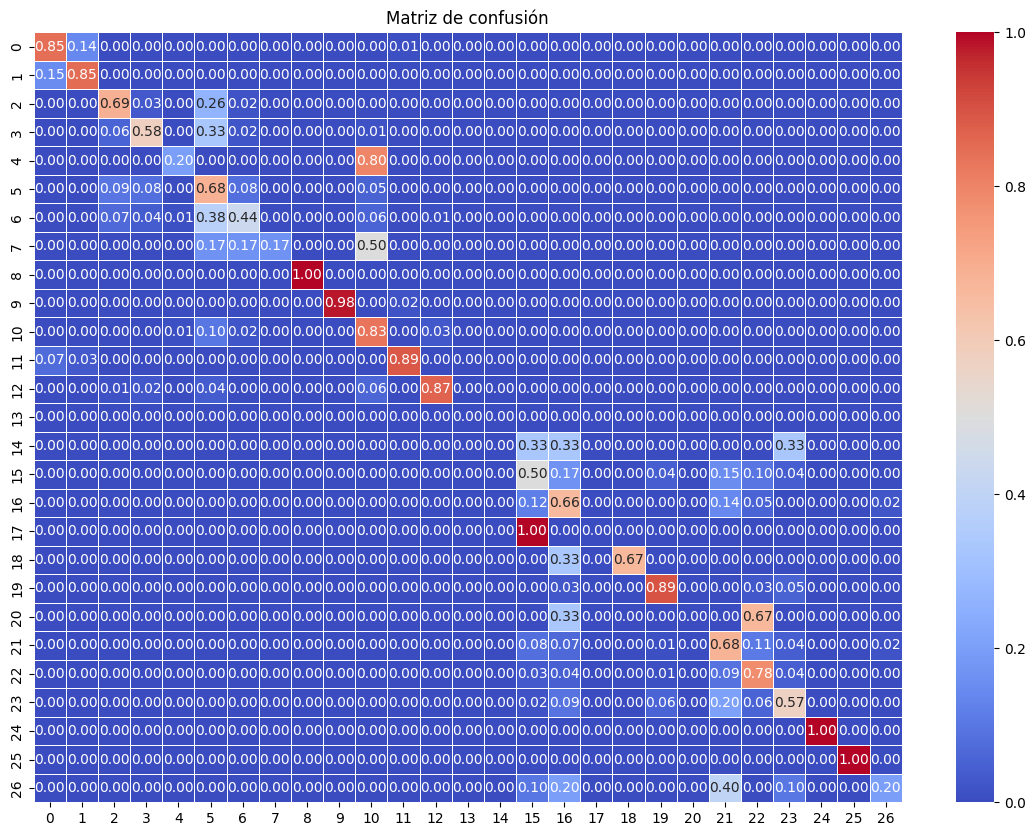

In [34]:
labels = le.classes_ 
cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
cr = classification_report(y_true, y_pred, digits=4)
print(cr)
plt.figure(figsize=(14, 10))
sns.heatmap(cm_norm, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5 )
plt.title('Matriz de confusión')


### Probabilidad asignada a cada clase y top 10 menor confianza
- p_true: probabilidad que el modelo le da a la clase real

In [38]:
# Probabilidad
p_true = y_proba[np.arange(len(y_test_enc)), y_test_enc]

# top10
top_10 = np.argsort(p_true)[:10]
id_top10 = X_test.index[top_10]

In [46]:
df_top10 = pd.DataFrame({
    "p_true": p_true[top_10],
    "y_true": y_true.loc[id_top10].values,
    "y_pred": y_pred[top_10],
    "max_proba": y_proba[top_10].max(axis=1),
    "pred_class": le.inverse_transform(y_proba[top_10].argmax(axis=1)),
}, index=id_top10).sort_values("p_true")
df_top10 = df_top10.join(ids_test.loc[df_top10.index])

df_top10

,p_true,y_true,y_pred,max_proba,pred_class,P_ID,TAX_MAP
39744,0.000033,24,4,0.765680,4,70863.0,116-0561-0005
40547,0.000067,24,14,0.904774,14,70862.0,116-0561-0004
10493,0.000068,70,72,0.484546,72,9593.0,030-0452-0000
39397,0.000076,24,6,0.828498,6,70859.0,116-0561-0001
7880,0.000080,10,14,0.756947,14,4566.0,015-0467-0000
25107,0.000108,5,14,0.982026,14,29349.0,077-0044-0000
24073,0.000234,6,5,0.659288,5,24687.0,065-0612-0000
38007,0.000237,10,14,0.995301,14,28843.0,074-0396-0000
42036,0.000268,24,14,0.656653,14,70861.0,116-0561-0003
7438,0.000322,10,7,0.682949,7,20428.0,056-0273-LL01
